## Import required packages

In [27]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import seaborn as sns

In [28]:
test = pd.read_csv('data/Student_Performance.csv')

## EDA

In [29]:
test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [30]:
test.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [31]:
print(test.shape)
print(test.describe())  

(10000, 6)
       Hours Studied  Previous Scores   Sleep Hours  \
count   10000.000000     10000.000000  10000.000000   
mean        4.992900        69.445700      6.530600   
std         2.589309        17.343152      1.695863   
min         1.000000        40.000000      4.000000   
25%         3.000000        54.000000      5.000000   
50%         5.000000        69.000000      7.000000   
75%         7.000000        85.000000      8.000000   
max         9.000000        99.000000      9.000000   

       Sample Question Papers Practiced  Performance Index  
count                      10000.000000       10000.000000  
mean                           4.583300          55.224800  
std                            2.867348          19.212558  
min                            0.000000          10.000000  
25%                            2.000000          40.000000  
50%                            5.000000          55.000000  
75%                            7.000000          71.000000  
max  

## Feature Selection
* Hours Studied
* Previous Score
* Extracurricular Activites
* Sleep Hours
* Sample question papers practiced


In [32]:
Target_Feature="Performance Index"

## Preprocessing

In [33]:
test["Extracurricular Activities"].dtype 
test["Extracurricular Activities"] = test["Extracurricular Activities"].fillna('No')

## Feature Engineering
#### Mapping Extracurricular acitvites with a meaningful feature

In [34]:
activity_map = {'no': 0, 'yes': 1}

test["Extracurricular Activities"] = (
    test["Extracurricular Activities"]
        .str.strip()
        .str.lower()
        .map(activity_map)
)

test = test.fillna(test.median(numeric_only=True))
test = test.fillna('missing value')

## Test Train split 
#### for seperating Training and Test Data

In [35]:
X = test.drop(columns=[Target_Feature])
y = test[Target_Feature]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## MSE 
Mean Squared Error - measures the average squared difference between estimated values and the actual value

## RMSE 
Root Mean Squared Error - measures the average magnitude of prediction errors, indicating how far, on average, predicted values deviate from actual observed values

## R2 Score
The R-squared R^2 score, or coefficient of determination, measures the proportion of variance in a dependent variable explained by independent variables in a regression model.

In [36]:
#poly = PolynomialFeatures(degree=2, include_bias=False)

#X_train_poly = poly.fit_transform(X_train)
#X_test_poly = poly.transform(X_test)
#model = LinearRegression()
#model.fit(X_train_poly, y_train)
#y_pred = model.predict(X_test_poly)
for r in range(1,3):
    poly_model = Pipeline([
        ("poly", PolynomialFeatures(degree=r, include_bias=False)),
        ("linear", LinearRegression())
    ])

    poly_model.fit(X_train, y_train)
    y_pred = poly_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("Polynomial Degree is: ",r)
    print("MSE:",mse)
    print("RMSE:", rmse)
    print("R2 Score:", r2)
    print("=======================")

Polynomial Degree is:  1
MSE: 4.082628398521857
RMSE: 2.0205515085050063
R2 Score: 0.9889832909573145
Polynomial Degree is:  2
MSE: 4.0806431061514665
RMSE: 2.020060173893705
R2 Score: 0.988988648140549


### Residual Plotting 
Scattered distirbution of diffrences in Test and Predicted results. 

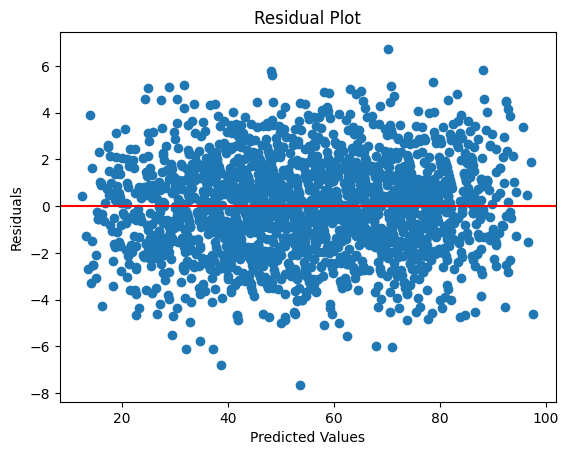

In [37]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(0, color='red')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

## The Variance Inflation Factor (VIF) 
measures how much the variance of a regression coefficient is inflated due to multicollinearity 
(correlation) among predictor variables.

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = pd.DataFrame()
X_vif["Feature"] = X.columns
X_vif["VIF"] = [variance_inflation_factor(X.values, i)
                for i in range(X.shape[1])]

print(X_vif)


                            Feature        VIF
0                     Hours Studied   4.263244
1                   Previous Scores  10.088586
2        Extracurricular Activities   1.928235
3                       Sleep Hours   9.833594
4  Sample Question Papers Practiced   3.350481


In [39]:
print("Train R2:", poly_model.score(X_train, y_train))
print("Test R2:", poly_model.score(X_test, y_test))


Train R2: 0.9887046501591211
Test R2: 0.988988648140549


### Learning Curve

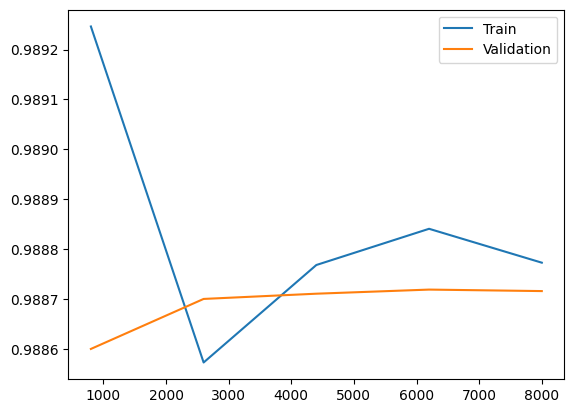

In [40]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    poly_model, X, y, cv=5, scoring="r2"
)

plt.plot(train_sizes, train_scores.mean(axis=1), label="Train")
plt.plot(train_sizes, val_scores.mean(axis=1), label="Validation")
plt.legend()
plt.show()